In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from cswNets import *

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/Users/abeukers/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# proto csw: next state questions, conditioned transitions

In [2]:
vocab = {
   # states
  'begin':0,
  'push':1,'step':2,
  'splash':3,'crumble':4,
  'end':5,
   # fillers
  'alice':6,'bob':7,
  'claire':8,'dave':9}

# story structures
s1 = 'begin %s push %s splash %s end' 
s2 = 'begin %s push %s crumble %s end'
s3 = 'begin %s step %s splash %s end'
s4 = 'begin %s step %s crumble %s end'

def f(s,x,y):
  """takes in structure and fillers, returns story"""
  filled = s % (x,y,x)
  story = [vocab[w] for w in filled.split()]
  return story

def make_story_L(s_L,x,y):
  """ takes list of structures, returns list of stories"""
  story_L = []
  for s in s_L:
    story_L.append(f(s,x,y))
  return story_L

### transition statistics

In [3]:
s_L = [s1,s1,s1,s2]
train_story_L = make_story_L(s_L,'dave','alice')
s_L = [s1,s2,s2,s2]
train_story_L.extend(make_story_L(s_L,'dave','bob'))

s_L = [s1,s1,s1,s2]
test_story_L = make_story_L(s_L,'claire','alice')
s_L = [s1,s2,s2,s2]
test_story_L.extend(make_story_L(s_L,'claire','bob'))

### sample stories

In [4]:
train_story_L

[[0, 9, 1, 6, 3, 9, 5],
 [0, 9, 1, 6, 3, 9, 5],
 [0, 9, 1, 6, 3, 9, 5],
 [0, 9, 1, 6, 4, 9, 5],
 [0, 9, 1, 7, 3, 9, 5],
 [0, 9, 1, 7, 4, 9, 5],
 [0, 9, 1, 7, 4, 9, 5],
 [0, 9, 1, 7, 4, 9, 5]]

In [5]:
def make_transition_dataset(story_L):
  """ given a list of stories,
      makes X,Y datasets for training """
  X = []
  Y = []
  for story in story_L:
    x = [story[0:2],story[2:4],story[4:6]]
    y = [[story[2]],[story[4]],[story[6]]]
    X.extend(x)
    Y.extend(y)
  return X,Y

X_train,Y_train = make_transition_dataset(train_story_L)
X_test,Y_test = make_transition_dataset(test_story_L)

In [6]:
vocab_size = len(vocab)

## cells and architectures

In [7]:
arch = {'input_seq_len':2,
       'output_seq_len':1,
       'celldim': vocab_size,
       'fix_vocab_size': vocab_size,
       'rand_vocab_size': 0,
       'embed_size': vocab_size}

## train and eval

In [8]:
train_info = {'batch_size': 15,
              'num_epochs': 3000,
              'loss_op': tf.losses.mean_squared_error}

In [16]:
lstm = LSTM(arch,saving=False)
rnn = RNN(arch,saving=False)

In [17]:
def run_k_experiments(net,train_info,k):
  acc_L = []
  for it in range(k):
    time1 = dt.now()
    net.reinitialize()
    eval_data = net.train(X_train,Y_train,train_info,
                          X_test,Y_test,train_info)
    acc_L.append(eval_data['accuracy'])
    print(it+1,dt.now()-time1)
  return np.array(acc_L)

In [21]:
rnn_acc_L = run_k_experiments(rnn,train_info,3)
lstm_acc_L = run_k_experiments(lstm,train_info,3)

reinitialize
1 0:00:13.489613
reinitialize
2 0:00:13.297095
reinitialize
3 0:00:13.895273
reinitialize
1 0:00:15.749483
reinitialize
2 0:00:15.001612
reinitialize
3 0:00:15.047429


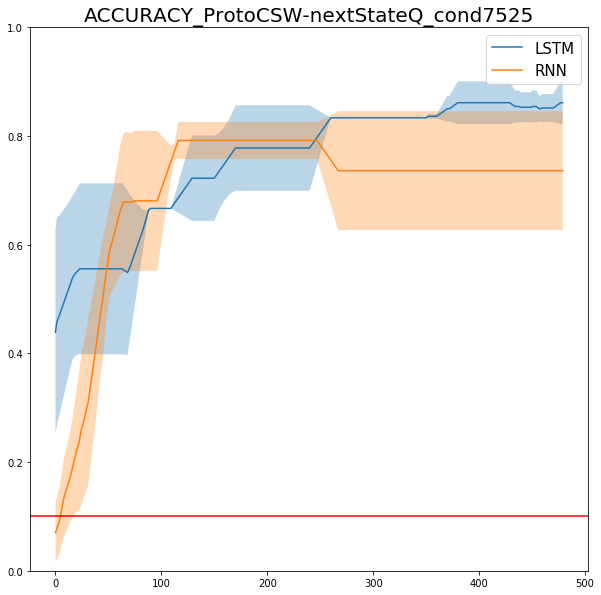

In [22]:
def mov_avg(X,wind):
  X_L = []
  for i in range(X.shape[1]-wind):
    x = np.mean(X[:,i:i+wind],1)
    X_L.append(x)
  return np.array(X_L)

mov_avg_wind = 20

plt.figure(figsize=(10,10))
plt.ylim((0,1))


M = np.mean(mov_avg(lstm_acc_L,mov_avg_wind),1)
sd = np.std(mov_avg(lstm_acc_L,mov_avg_wind),1)
plt.plot(M,label='LSTM')
plt.fill_between(range(len(M)),M-sd,M+sd,alpha=.3)
  
M = np.mean(mov_avg(rnn_acc_L,mov_avg_wind),1)
sd = np.std(mov_avg(rnn_acc_L,mov_avg_wind),1)
plt.plot(M,label='RNN')
plt.fill_between(range(len(M)),M-sd,M+sd,alpha=.3)

plt.axhline(1/(vocab_size),c='r')
plt.legend(fontsize=15)
title = 'ACCURACY_ProtoCSW-nextStateQ_cond7525'
plt.title(title,size=20)
plt.savefig(title)